# <div align = 'center'>Model Building</div>

###### Models to be used in this problem

* LogisticRegression
* MulltinomialNB
* DecisionTreeClassifier
* ExtraTreesClassifier
* RandomForestClassifier
* AdaBoostClassifier
* GradientBoostingClassifier
* XGBClassifier
* CatBoostClassifier

In [ ]:
!nvidia-smi

Tue Apr 13 13:15:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

###### Creating a base model without any imputations or treatment. Only null values have been treated

In [ ]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
  inflating: Data/capstone_train.csv  
  inflating: Data/filled_train_28-03.csv  


In [2]:
df = pd.read_csv('Data/capstone_train.csv')
df.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [3]:
#Basic immputations
df = df.drop('Loan_ID',axis  =1)
import string
def remove_punctuation(x):
    if len(x.split(','))>1:
        return int(x.split(',')[0]+x.split(',')[1])
    else:
        return int(x)
df['Loan_Amount_Requested'] = df['Loan_Amount_Requested'].apply(remove_punctuation)

In [4]:
#Filling Length Employed with mode since only 0.04% of values are missing
df['Length_Employed'] = df['Length_Employed'].fillna(df['Length_Employed'].mode().values[0])

In [5]:
#Filling home owner with max type of home for each employment level.
mapper = dict(df.groupby(['Length_Employed','Home_Owner'])['Home_Owner'].count().sort_values().groupby(level = 0).tail(1).index)
mapper
import math
for i in df[df['Home_Owner'].isna()].index:
    if math.isnan(df['Home_Owner'][i]) == True:
        df['Home_Owner'][i] = mapper[df['Length_Employed'][i]]

In [6]:
def len_emp(x):
    if x.split()[0]=='<':
        return 0
    else:
        return int(x.strip().strip('<').strip('year').strip('years').strip().strip('+'))
df['Length_Employed'] = df['Length_Employed'].apply(len_emp)

In [7]:
df['Months_Since_Deliquency'] = df['Months_Since_Deliquency'].fillna(360)

In [8]:
#Since Months_Since_Deliquency does not seem to show much of an impact on interest_rates we will drop it.
import time
start = time.time()
#Length_Employed can be filled based on annual_income.
#Annual_Income will be filled using KNNImputer on the numerical columns only.
#Home_Owner will be taken care of later.
knn_impute_data=df.select_dtypes(np.number)
#Standardizing the dataset for the KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
ss = StandardScaler()
scaled = pd.DataFrame(ss.fit_transform(knn_impute_data.drop(['Interest_Rate','Months_Since_Deliquency'],axis = 1)),columns = knn_impute_data.drop(['Interest_Rate','Months_Since_Deliquency'],axis = 1).columns)
filled_scaled = KNNImputer(n_neighbors = 5).fit_transform(X = scaled,y = knn_impute_data['Interest_Rate'])
end = time.time()
print('Execution Time:',end-start)

Execution Time: 511.99867367744446


In [9]:
filled_unscaled = pd.DataFrame(ss.inverse_transform(filled_scaled),columns = knn_impute_data.drop(['Interest_Rate','Months_Since_Deliquency'],axis = 1).columns)
fill_data = pd.concat((round(filled_unscaled.reset_index(drop = True)),df.select_dtypes('object').reset_index(drop = True),df['Months_Since_Deliquency'].reset_index(drop = True),df['Interest_Rate'].reset_index(drop = True)),axis = 1)

In [10]:
fill_data.head()

,Loan_Amount_Requested,Length_Employed,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Home_Owner,Income_Verified,Purpose_Of_Loan,Gender,Months_Since_Deliquency,Interest_Rate
0,7000.0,0.0,68000.0,18.0,0.0,9.0,14.0,Rent,not verified,car,Female,360.0,1
1,30000.0,4.0,110400.0,15.0,0.0,12.0,24.0,Mortgage,VERIFIED - income,debt_consolidation,Female,17.0,3
2,24725.0,7.0,75566.0,16.0,0.0,12.0,16.0,Mortgage,VERIFIED - income source,debt_consolidation,Male,360.0,3
3,16000.0,0.0,56160.0,14.0,3.0,16.0,22.0,Rent,VERIFIED - income source,debt_consolidation,Male,360.0,3
4,17000.0,8.0,96000.0,22.0,1.0,19.0,30.0,Own,VERIFIED - income source,debt_consolidation,Female,360.0,1


In [11]:
df_d = pd.get_dummies(fill_data,drop_first = True)
df_d.head()

,Loan_Amount_Requested,Length_Employed,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Months_Since_Deliquency,Interest_Rate,Home_Owner_None,...,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Gender_Male
0,7000.0,0.0,68000.0,18.0,0.0,9.0,14.0,360.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,30000.0,4.0,110400.0,15.0,0.0,12.0,24.0,17.0,3,0,...,0,0,0,0,0,0,0,0,0,0
2,24725.0,7.0,75566.0,16.0,0.0,12.0,16.0,360.0,3,0,...,0,0,0,0,0,0,0,0,0,1
3,16000.0,0.0,56160.0,14.0,3.0,16.0,22.0,360.0,3,0,...,0,0,0,0,0,0,0,0,0,1
4,17000.0,8.0,96000.0,22.0,1.0,19.0,30.0,360.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X = df_d.drop('Interest_Rate',axis = 1)
y = df_d['Interest_Rate']

In [13]:
#Base Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 2)
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           1       0.21      0.00      0.00      6735
           2       0.45      0.68      0.54     14149
           3       0.48      0.45      0.47     11978

    accuracy                           0.46     32862
   macro avg       0.38      0.38      0.34     32862
weighted avg       0.41      0.46      0.40     32862



# Importing the final data after changes for model building

In [ ]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
  inflating: Data/capstone_train.csv  
  inflating: Data/filled_train_28-03.csv  


In [ ]:
data = pd.read_csv('Data/filled_train_28-03.csv')
data.head()

,Loan_Amount_Requested,Length_Employed,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Home_Owner,Income_Verified,Purpose_Of_Loan,Gender,Months_Since_Deliquency,Interest_Rate
0,7000.0,0.0,68000.0,18.0,0.0,9.0,14.0,Rent,not verified,car,Female,NaN,1
1,30000.0,4.0,98367.0,15.0,0.0,12.0,24.0,Mortgage,VERIFIED - income,debt_consolidation,Female,17.0,3
2,24725.0,7.0,75566.0,16.0,0.0,12.0,16.0,Mortgage,VERIFIED - income,debt_consolidation,Male,NaN,3
3,17000.0,8.0,96000.0,22.0,1.0,19.0,30.0,Own,VERIFIED - income,debt_consolidation,Female,NaN,1
4,4500.0,2.0,30000.0,11.0,1.0,12.0,15.0,Rent,VERIFIED - income,credit_card,Male,NaN,3


## Applying transformations to the data

In [ ]:
data['Months_Since_Deliquency'] = data['Months_Since_Deliquency'].fillna(360) 

###### Visualizing distributions

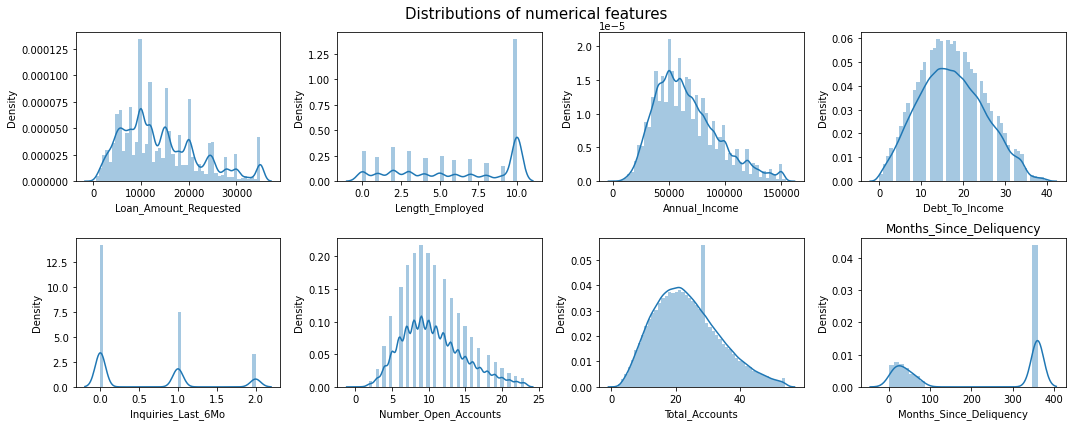

In [ ]:
data_dist = data.select_dtypes(np.number).drop('Interest_Rate',axis = 1)
fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize = (15,6))
for variables,plotsubs in zip(data_dist.columns,ax.flatten()):
    plt.title(variables)
    plotsubs.tick_params(labelsize = 10)
    plotsubs.set_xlabel(variables,fontsize = 10)
    sns.distplot(data_dist[variables],ax = plotsubs)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.92) 
fig.suptitle('Distributions of numerical features',fontsize = 15)
plt.show()

###### Checking skew values

In [ ]:
for i in data_dist.columns:
    print(i,data[i].skew())

Loan_Amount_Requested 0.7540805981561574
Length_Employed -0.3143341220629363
Annual_Income 0.7405019759073301
Debt_To_Income 0.19364066386276518
Inquiries_Last_6Mo 0.865342680130085
Number_Open_Accounts 0.5694792245898963
Total_Accounts 0.49643669533172174
Months_Since_Deliquency -0.21034759166221614


In [ ]:
data1 = data.copy()

###### Extra: To transform bimodal data

* Calculate absolute difference of mean with rest of the data
* Would work when both mode data is equal or we have 2 equal peaks

In [ ]:
data1['Loan_Amount_Requested'] = np.sqrt(data1['Loan_Amount_Requested'])
data1['Annual_Income'] = stats.boxcox(data1['Annual_Income'])[0]
data1['Number_Open_Accounts'] = np.sqrt(data1['Number_Open_Accounts'])
data1['Total_Accounts'] = np.sqrt(data1['Total_Accounts'])
data1['Months_Since_Deliquency'] = np.log(abs(data['Months_Since_Deliquency']-np.mean(data['Months_Since_Deliquency'])))
#Months_Since_Deliquency is sort of multi-modal

In [ ]:
def emp(x):
    if x>=10:
        return '10+yrs'
    elif x>=6 and x<=9:
        return '6-9 yrs'
    elif x>=2 and x<=5:
        return '2-5 yrs'
    else:
        return '0-1 yrs'

data1['Length_Employed'] = data1['Length_Employed'].apply(emp)

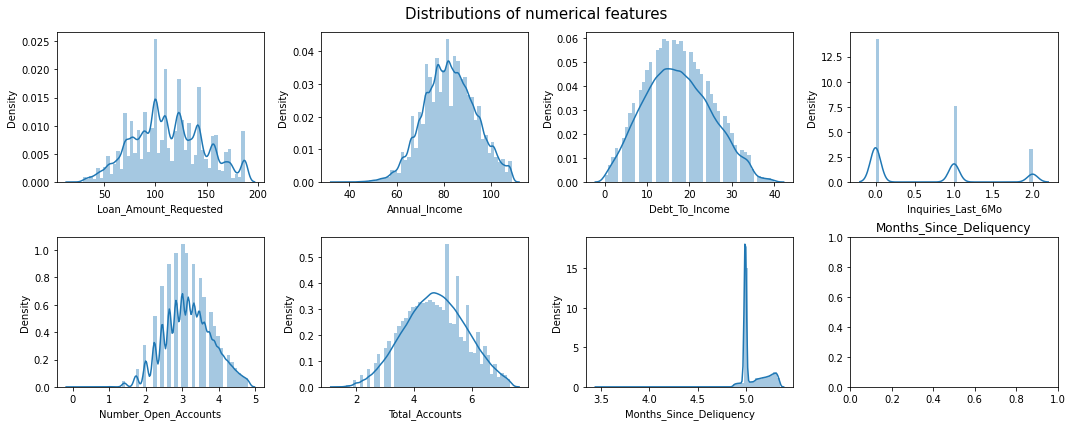

In [ ]:
data_dist = data1.select_dtypes(np.number).drop('Interest_Rate',axis = 1)
fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize = (15,6))
for variables,plotsubs in zip(data_dist.columns,ax.flatten()):
    plt.title(variables)
    plotsubs.tick_params(labelsize = 10)
    plotsubs.set_xlabel(variables,fontsize = 10)
    sns.distplot(data_dist[variables],ax = plotsubs)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.92) 
fig.suptitle('Distributions of numerical features',fontsize = 15)
plt.show()

In [ ]:
for i in data_dist.columns:
    print(i,data1[i].skew())

Loan_Amount_Requested 0.1291482087608808
Annual_Income -0.008845322404628491
Debt_To_Income 0.19364066386276518
Inquiries_Last_6Mo 0.865342680130085
Number_Open_Accounts 0.07119574809932888
Total_Accounts -0.02602900192630502
Months_Since_Deliquency 0.8571224339511455


# Applying SFS and RFE 

In [ ]:
X = pd.get_dummies(data1).drop('Interest_Rate',axis = 1)
y = data1['Interest_Rate']

In [ ]:
#Performing Sequential Feature Selector operation to see which features are playing a signinficant role in determining the interest rate.
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier
fs = SFS(estimator = DecisionTreeClassifier(),
                     k_features = "best",
                     scoring = 'f1_weighted',
                     n_jobs = -1,
                     verbose = 0)
sfsmodel = fs.fit(X,y)
print('Best features for predicting Interest Rate:\n',sfsmodel.k_feature_names_)
print()
print('Overall best F1 Score:\n',sfsmodel.k_score_)

Best features for predicting Interest Rate:
 ('Loan_Amount_Requested', 'Inquiries_Last_6Mo', 'Home_Owner_None', 'Home_Owner_Other', 'Income_Verified_VERIFIED - income', 'Income_Verified_not verified', 'Purpose_Of_Loan_car', 'Purpose_Of_Loan_credit_card', 'Purpose_Of_Loan_debt_consolidation', 'Purpose_Of_Loan_educational', 'Purpose_Of_Loan_home_improvement', 'Purpose_Of_Loan_major_purchase', 'Purpose_Of_Loan_moving', 'Purpose_Of_Loan_renewable_energy')

Overall best F1 Score:
 0.46340205265173495


Best features for predicting Interest Rate:
 ('Loan_Amount_Requested', 'Inquiries_Last_6Mo', 'Home_Owner_None', 'Home_Owner_Other', 'Income_Verified_VERIFIED - income', 'Income_Verified_not verified', 'Purpose_Of_Loan_car', 'Purpose_Of_Loan_credit_card', 'Purpose_Of_Loan_debt_consolidation', 'Purpose_Of_Loan_educational', 'Purpose_Of_Loan_home_improvement', 'Purpose_Of_Loan_major_purchase', 'Purpose_Of_Loan_moving', 'Purpose_Of_Loan_renewable_energy')

Overall best F1 Score:
 0.46340205265173495

In [ ]:
from sklearn.feature_selection import RFE
n = 14
rfe = RFE(DecisionTreeClassifier(),n_features_to_select = n)
rfe.fit(X,y)
print('Best {} features for predicting Interest Rate:\n {}'.format(n,X.columns[rfe.get_support()]))
print()
print(rfe.score(X,y))

Best 14 features for predicting Interest Rate:
 Index(['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts',
       'Months_Since_Deliquency', 'Length_Employed_10+yrs',
       'Length_Employed_2-5 yrs', 'Length_Employed_6-9 yrs',
       'Home_Owner_Mortgage', 'Income_Verified_not verified',
       'Purpose_Of_Loan_debt_consolidation', 'Gender_Female'],
      dtype='object')

0.9999929725437283


Best 14 features for predicting Interest Rate:
 Index(['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts',
       'Months_Since_Deliquency', 'Length_Employed_10+yrs',
       'Length_Employed_2-5 yrs', 'Length_Employed_6-9 yrs',
       'Home_Owner_Mortgage', 'Income_Verified_not verified',
       'Purpose_Of_Loan_debt_consolidation', 'Gender_Female'],
      dtype='object')

0.9999929725437283

In [ ]:
#First creating a logistic regression model using the above features with standardization.

In [ ]:
X_sfs = X[['Loan_Amount_Requested', 'Inquiries_Last_6Mo', 'Home_Owner_None', 'Home_Owner_Other', 
           'Income_Verified_VERIFIED - income', 'Income_Verified_not verified', 'Purpose_Of_Loan_car', 
           'Purpose_Of_Loan_credit_card', 'Purpose_Of_Loan_debt_consolidation', 'Purpose_Of_Loan_educational', 
           'Purpose_Of_Loan_home_improvement', 'Purpose_Of_Loan_major_purchase', 'Purpose_Of_Loan_moving', 
           'Purpose_Of_Loan_renewable_energy']]

X_rfe = X[['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income',
       'Inquiries_Last_6Mo', 'Number_Open_Accounts', 'Total_Accounts',
       'Months_Since_Deliquency', 'Length_Employed_10+yrs',
       'Length_Employed_2-5 yrs', 'Length_Employed_6-9 yrs',
       'Home_Owner_Mortgage', 'Income_Verified_not verified',
       'Purpose_Of_Loan_debt_consolidation', 'Gender_Female']]

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_sfs_std = ss.fit_transform(X_sfs)
X_rfe_std = ss.fit_transform(X_rfe)

# Logistic Regression

In [ ]:
fscore = []
accuracy=[]
vals = [['sfs','sfs_std','rfe','rfe_std'],fscore,accuracy]
cols = ['Feature Selection Technique','F1-Score','Accuracy']

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

avg_f1_score = np.mean(cross_val_score(lr,X_sfs,y, cv = 5,verbose = 1,scoring='f1_weighted',n_jobs = 1))
avg_accuracy_score = np.mean(cross_val_score(lr,X_sfs,y, cv = 5,scoring='accuracy',n_jobs = 1))
fscore.append(avg_f1_score)
accuracy.append(avg_accuracy_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.7s finished


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

avg_f1_score = np.mean(cross_val_score(lr,X_sfs_std,y, cv = 5,verbose = 1,scoring='f1_weighted',n_jobs = 1))
avg_accuracy_score = np.mean(cross_val_score(lr,X_sfs_std,y, cv = 5,scoring='accuracy',n_jobs = 1))
fscore.append(avg_f1_score)
accuracy.append(avg_accuracy_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s finished


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

avg_f1_score = np.mean(cross_val_score(lr,X_rfe,y, cv = 5,verbose = 1,scoring='f1_weighted',n_jobs = 1))
avg_accuracy_score = np.mean(cross_val_score(lr,X_rfe,y, cv = 5,scoring='accuracy',n_jobs = 1))
fscore.append(avg_f1_score)
accuracy.append(avg_accuracy_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   46.3s finished


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

avg_f1_score = np.mean(cross_val_score(lr,X_rfe_std,y, cv = 5,verbose = 1,scoring='f1_weighted',n_jobs = 1))
avg_accuracy_score = np.mean(cross_val_score(lr,X_rfe_std,y, cv = 5,scoring='accuracy',n_jobs = 1))
fscore.append(avg_f1_score)
accuracy.append(avg_accuracy_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.6s finished


In [ ]:
pd.DataFrame(dict(zip(cols,vals)))

,Feature Selection Technique,F1-Score,Accuracy
0,sfs,0.434845,0.495267
1,sfs_std,0.441312,0.498155
2,rfe,0.477117,0.500011
3,rfe_std,0.483583,0.504037


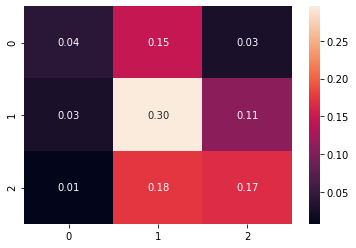

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_rfe_std,y,test_size = 0.2,random_state = 1)
lr.fit(X_train,y_train)
pred = pd.Series(lr.predict(X_test))
pred.value_counts()
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test,pred)/len(pred),annot = True,fmt = '.2f')

##### RFE features seem to be performing much better. We will be creating the rest of the models using the RFE features

In [ ]:

f_dtc = []
acc_dtc = []
data_type = []
ml_model = []
vals = [ml_model,data_type,f_dtc,acc_dtc]
cols = ['Model','Data Type','F1-Score','Accuracy']

# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [ ]:
avg_f1_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score)
acc_dtc.append(avg_accuracy_score)
data_type.append('Not Standardized')
ml_model.append('DecisionTreeClassifier')

avg_f1_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score_std)
acc_dtc.append(avg_accuracy_score_std)
data_type.append('Standardized')
ml_model.append('DecisionTreeClassifier')

pd.DataFrame(dict(zip(cols,vals)))

,Model,Data Type,F1-Score,Accuracy
0,DecisionTreeClassifier,Not Standardized,0.416821,0.416335
1,DecisionTreeClassifier,Standardized,0.416758,0.417171


# Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

In [ ]:
dtc = mnb
avg_f1_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score)
acc_dtc.append(avg_accuracy_score)
data_type.append('Not Standardized')
ml_model.append('Naive Bayes Classifier')

avg_f1_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score_std)
acc_dtc.append(avg_accuracy_score_std)
data_type.append('Standardized')
ml_model.append('Naive Bayes Classifier')

pd.DataFrame(dict(zip(cols,vals)))

,Model,Data Type,F1-Score,Accuracy
0,DecisionTreeClassifier,Not Standardized,0.416821,0.416335
1,DecisionTreeClassifier,Standardized,0.416758,0.417171
2,RandomForestClassifier,Not Standardized,0.484381,0.495330
3,RandomForestClassifier,Standardized,0.484153,0.495098
4,Naive Bayes Classifier,Not Standardized,0.458256,0.464866
5,Naive Bayes Classifier,Standardized,NaN,NaN


# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [ ]:
dtc = rfc
avg_f1_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score)
acc_dtc.append(avg_accuracy_score)
data_type.append('Not Standardized')
ml_model.append('RandomForestClassifier')

avg_f1_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score_std)
acc_dtc.append(avg_accuracy_score_std)
data_type.append('Standardized')
ml_model.append('RandomForestClassifier')

pd.DataFrame(dict(zip(cols,vals)))

,Model,Data Type,F1-Score,Accuracy
0,DecisionTreeClassifier,Not Standardized,0.416821,0.416335
1,DecisionTreeClassifier,Standardized,0.416758,0.417171
2,RandomForestClassifier,Not Standardized,0.484381,0.495330
3,RandomForestClassifier,Standardized,0.484153,0.495098


# ExtraTreesClassifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

In [ ]:
dtc = etc
avg_f1_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score)
acc_dtc.append(avg_accuracy_score)
data_type.append('Not Standardized')
ml_model.append('ExtraTreesClassifier')

avg_f1_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score_std)
acc_dtc.append(avg_accuracy_score_std)
data_type.append('Standardized')
ml_model.append('ExtraTreesClassifier')

pd.DataFrame(dict(zip(cols,vals)))

,Model,Data Type,F1-Score,Accuracy
0,DecisionTreeClassifier,Not Standardized,0.416821,0.416335
1,DecisionTreeClassifier,Standardized,0.416758,0.417171
2,RandomForestClassifier,Not Standardized,0.484381,0.495330
3,RandomForestClassifier,Standardized,0.484153,0.495098
4,Naive Bayes Classifier,Not Standardized,0.458256,0.464866
5,Naive Bayes Classifier,Standardized,NaN,NaN
6,ExtraTreesClassifier,Not Standardized,0.469124,0.481915
7,ExtraTreesClassifier,Standardized,0.469149,0.480039


# GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()

In [ ]:
dtc = gbc
avg_f1_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score)
acc_dtc.append(avg_accuracy_score)
data_type.append('Not Standardized')
ml_model.append('GradientBoostingClassifier')

avg_f1_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score_std)
acc_dtc.append(avg_accuracy_score_std)
data_type.append('Standardized')
ml_model.append('GradientBoostingClassifier')

pd.DataFrame(dict(zip(cols,vals)))

,Model,Data Type,F1-Score,Accuracy
0,DecisionTreeClassifier,Not Standardized,0.416821,0.416335
1,DecisionTreeClassifier,Standardized,0.416758,0.417171
2,RandomForestClassifier,Not Standardized,0.484381,0.495330
3,RandomForestClassifier,Standardized,0.484153,0.495098
4,Naive Bayes Classifier,Not Standardized,0.458256,0.464866
5,Naive Bayes Classifier,Standardized,NaN,NaN
6,ExtraTreesClassifier,Not Standardized,0.469124,0.481915
7,ExtraTreesClassifier,Standardized,0.469149,0.480039
8,GradientBoostingClassifier,Not Standardized,0.497880,0.518331
9,GradientBoostingClassifier,Standardized,0.497880,0.518331


# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

In [ ]:
dtc = abc
avg_f1_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score)
acc_dtc.append(avg_accuracy_score)
data_type.append('Not Standardized')
ml_model.append('AdaBoostClassifier')

avg_f1_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score_std)
acc_dtc.append(avg_accuracy_score_std)
data_type.append('Standardized')
ml_model.append('AdaBoostClassifier')

pd.DataFrame(dict(zip(cols,vals)))

,Model,Data Type,F1-Score,Accuracy
0,DecisionTreeClassifier,Not Standardized,0.416821,0.416335
1,DecisionTreeClassifier,Standardized,0.416758,0.417171
2,RandomForestClassifier,Not Standardized,0.484381,0.495330
3,RandomForestClassifier,Standardized,0.484153,0.495098
4,Naive Bayes Classifier,Not Standardized,0.458256,0.464866
5,Naive Bayes Classifier,Standardized,NaN,NaN
6,ExtraTreesClassifier,Not Standardized,0.469124,0.481915
7,ExtraTreesClassifier,Standardized,0.469149,0.480039
8,GradientBoostingClassifier,Not Standardized,0.497880,0.518331
9,GradientBoostingClassifier,Standardized,0.497880,0.518331


# XGBoost

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [ ]:
dtc = xgb
avg_f1_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score)
acc_dtc.append(avg_accuracy_score)
data_type.append('Not Standardized')
ml_model.append('XGBClassifier')

avg_f1_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score_std)
acc_dtc.append(avg_accuracy_score_std)
data_type.append('Standardized')
ml_model.append('XGBClassifier')

pd.DataFrame(dict(zip(cols,vals)))

,Model,Data Type,F1-Score,Accuracy
0,DecisionTreeClassifier,Not Standardized,0.416821,0.416335
1,DecisionTreeClassifier,Standardized,0.416758,0.417171
2,RandomForestClassifier,Not Standardized,0.484381,0.495330
3,RandomForestClassifier,Standardized,0.484153,0.495098
4,Naive Bayes Classifier,Not Standardized,0.458256,0.464866
5,Naive Bayes Classifier,Standardized,NaN,NaN
6,ExtraTreesClassifier,Not Standardized,0.469124,0.481915
7,ExtraTreesClassifier,Standardized,0.469149,0.480039
8,GradientBoostingClassifier,Not Standardized,0.497880,0.518331
9,GradientBoostingClassifier,Standardized,0.497880,0.518331


# CatBoost

In [1]:
# !pip install catboost

In [ ]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier()

In [ ]:
dtc = cb
avg_f1_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score)
acc_dtc.append(avg_accuracy_score)
data_type.append('Not Standardized')
ml_model.append('CatBoostClassifier')

avg_f1_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
f_dtc.append(avg_f1_score_std)
acc_dtc.append(avg_accuracy_score_std)
data_type.append('Standardized')
ml_model.append('CatBoostClassifier')

pd.DataFrame(dict(zip(cols,vals)))

,Model,Data Type,F1-Score,Accuracy
0,DecisionTreeClassifier,Not Standardized,0.416821,0.416335
1,DecisionTreeClassifier,Standardized,0.416758,0.417171
2,RandomForestClassifier,Not Standardized,0.484381,0.495330
3,RandomForestClassifier,Standardized,0.484153,0.495098
4,Naive Bayes Classifier,Not Standardized,0.458256,0.464866
5,Naive Bayes Classifier,Standardized,NaN,NaN
6,ExtraTreesClassifier,Not Standardized,0.469124,0.481915
7,ExtraTreesClassifier,Standardized,0.469149,0.480039
8,GradientBoostingClassifier,Not Standardized,0.497880,0.518331
9,GradientBoostingClassifier,Standardized,0.497880,0.518331


In [ ]:
inf = pd.DataFrame(dict(zip(cols,vals)))
inf.sort_values('Accuracy',ascending = False)

,Model,Data Type,F1-Score,Accuracy
14,CatBoostClassifier,Not Standardized,0.512051,0.524326
15,CatBoostClassifier,Standardized,0.512051,0.524326
12,XGBClassifier,Not Standardized,0.511055,0.523300
13,XGBClassifier,Standardized,0.511039,0.523285
8,GradientBoostingClassifier,Not Standardized,0.497880,0.518331
9,GradientBoostingClassifier,Standardized,0.497880,0.518331
10,AdaBoostClassifier,Not Standardized,0.495532,0.511746
11,AdaBoostClassifier,Standardized,0.495532,0.511746
2,RandomForestClassifier,Not Standardized,0.484381,0.495330
3,RandomForestClassifier,Standardized,0.484153,0.495098


In [ ]:
#Catboost seems to be performing the best

In [117]:
#Using the not standardized rfe dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_rfe,y,test_size = 0.2,random_state = 1)

In [ ]:
#Applying grid search for cat boost to find best parameters
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200]
          }

In [ ]:
cb1 = CatBoostClassifier(loss_function = 'MultiClass',thread_count = 4,verbose = 0,task_type = 'GPU')

In [ ]:
#Looking for each best parameter for each criterion with the default values first.
from sklearn.model_selection import GridSearchCV
ind = []
val = []
cols = ['Hyper-Parameter','Best_Val']
vals = [ind,val]
for i in params:
    grid = GridSearchCV(cb1,{i:params[i]},scoring = 'f1_weighted',n_jobs = -1,cv = 5)
    grid.fit(X_train,y_train)
    val.append(grid.best_params_[i])
    ind.append(i)
    print('{} is best for {} keeping all the other features as default'.format(grid.best_params_[i],i))

3 is best for depth keeping all the other features as default
100 is best for iterations keeping all the other features as default
0.1 is best for learning_rate keeping all the other features as default
5 is best for l2_leaf_reg keeping all the other features as default
200 is best for border_count keeping all the other features as default


In [ ]:
pd.DataFrame(dict(zip(cols,vals)))

,Hyper-Parameter,Best_Val
0,depth,3.0
1,iterations,100.0
2,learning_rate,0.1
3,l2_leaf_reg,5.0
4,border_count,200.0


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
cb1 = CatBoostClassifier(loss_function = 'MultiClass',thread_count = 4,verbose = 0,task_type = 'GPU',
                        depth = 3,iterations = 100,learning_rate = 0.1,l2_leaf_reg = 5,
                        border_count = 200)

In [ ]:
dtc = cb1
avg_f1_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_rfe,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
# f_dtc.append(avg_f1_score)
# acc_dtc.append(avg_accuracy_score)
# data_type.append('Not Standardized')
# ml_model.append('CatBoostClassifier')

avg_f1_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score_std = np.mean(cross_val_score(dtc,X_rfe_std,y,cv = 5,scoring = 'accuracy',n_jobs = -1))
# f_dtc.append(avg_f1_score_std)
# acc_dtc.append(avg_accuracy_score_std)
# data_type.append('Standardized')
# ml_model.append('CatBoostClassifier')

pd.DataFrame({'ML Model': ['CatBoostClassifier','CatBoostClassifier'],
              'Data_Type':['Not Std','Std'],
              'f1_score':[avg_f1_score,avg_f1_score_std],
              'accuracy_score':[avg_accuracy_score,avg_accuracy_score_std]})

,ML Model,Data_Type,f1_score,accuracy_score
0,CatBoostClassifier,Not Std,0.489391,0.513953
1,CatBoostClassifier,Std,0.489286,0.513974


In [ ]:
#Running grid search with all parameters together.

In [114]:
cb1 = CatBoostClassifier(loss_function = 'MultiClass',thread_count = 4,verbose = 0,task_type = 'GPU')

# Trying with custom parameters

In [118]:
params1 = {
    'depth':[2,3,4],
    'learning_rate':[0.05,0.1,0.15],
    'iterations':[50,100,200]
}

In [119]:
grid1 = GridSearchCV(cb1,params1,scoring = 'f1_weighted',n_jobs = -1,cv = 5)
grid1.fit(X_train,y_train)
grid.best_params_

{'border_count': 200}

# Fitting the model

In [120]:
#Final model accuracy
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

cb1 = CatBoostClassifier(loss_function = 'MultiClass',thread_count = 4,verbose = 0,task_type = 'GPU')

cb1.fit(X_train,y_train)

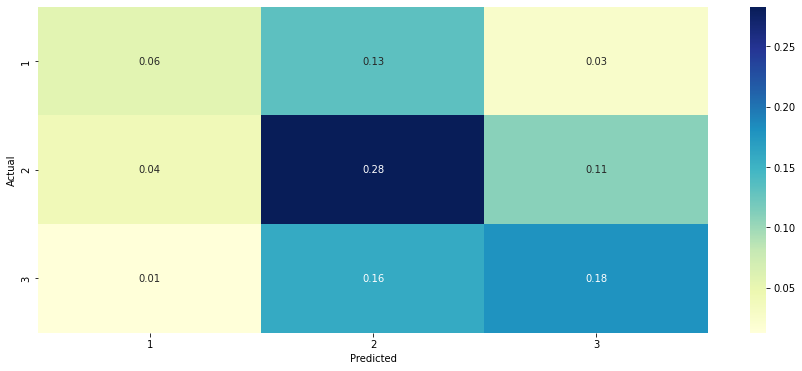

In [121]:
from sklearn.metrics import confusion_matrix
cat_pred = cb1.predict(X_test)
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_test,cat_pred)/len(cat_pred),annot = True,fmt = '.2f',cmap = 'YlGnBu')
plt.xlabel('Predicted')
plt.xticks(ticks = [0.5,1.5,2.5],labels = [1,2,3])
plt.yticks(ticks = [0.5,1.5,2.5],labels = [1,2,3],va = 'center')
plt.ylabel('Actual')
plt.show()

In [122]:
from sklearn.metrics import classification_report
print(classification_report(y_test,cat_pred))

              precision    recall  f1-score   support

           1       0.51      0.26      0.35      6121
           2       0.49      0.65      0.56     12323
           3       0.57      0.51      0.54     10016

    accuracy                           0.52     28460
   macro avg       0.53      0.48      0.48     28460
weighted avg       0.52      0.52      0.51     28460



# Applying SMOTE for some performance improvement.

In [135]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state = 2)
X_r,y_r = smt.fit_resample(X_rfe,y)

In [137]:
from sklearn.model_selection import train_test_split
X_train_r,X_test,y_train_r,y_test = train_test_split(X_r,y_r,test_size = 0.2,random_state = 1)

In [138]:
#Final model accuracy
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

cb2 = CatBoostClassifier(loss_function = 'MultiClass',thread_count = 4,
                         verbose = 0,task_type = 'GPU')

dtc = cb2
avg_f1_score = np.mean(cross_val_score(dtc,X_train_r,y_train_r,cv = 5,scoring = 'f1_weighted',n_jobs = -1))
avg_accuracy_score = np.mean(cross_val_score(dtc,X_train_r,y_train_r,cv = 5,scoring = 'accuracy',n_jobs = -1))

pd.DataFrame({'ML Model': ['CatBoostClassifier'],
              'f1_score':[avg_f1_score],
              'accuracy_score':[avg_accuracy_score]})

,ML Model,f1_score,accuracy_score
0,CatBoostClassifier,0.596795,0.593702


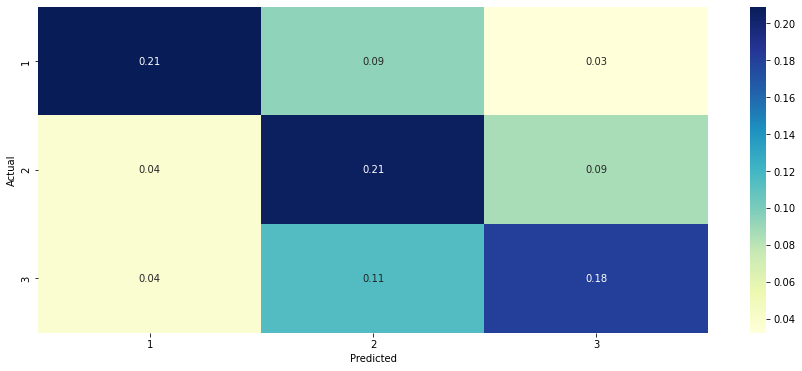

In [139]:
from sklearn.metrics import confusion_matrix
cb2.fit(X_train_r,y_train_r)
cat_pred2 = cb2.predict(X_test)
plt.figure(figsize = (15,6))
sns.heatmap(confusion_matrix(y_test,cat_pred2)/len(cat_pred2),annot = True,fmt = '.2f',cmap = 'YlGnBu')
plt.xlabel('Predicted')
plt.xticks(ticks = [0.5,1.5,2.5],labels = [1,2,3])
plt.yticks(ticks = [0.5,1.5,2.5],labels = [1,2,3],va = 'center')
plt.ylabel('Actual')
plt.show()

In [140]:
from sklearn.metrics import classification_report
print(classification_report(y_test,cat_pred2))

              precision    recall  f1-score   support

           1       0.73      0.62      0.67     12572
           2       0.50      0.62      0.55     12353
           3       0.61      0.54      0.57     12518

    accuracy                           0.60     37443
   macro avg       0.61      0.60      0.60     37443
weighted avg       0.61      0.60      0.60     37443



# Notebook Summary

###### Base Model

###### Data Transformations Done

* Imputing the months_Since_Deliquency with 360
* Taking square root for loan_amount_requested to reduce positive skew.
* Taking boxcox transformation of Annual_Income
* Taking square root for Number_Open_Accounts
* Taking square root for Total_Accounts
* Since Months_Since_Deliquency has become bimodal we will be taking the log of Months_Since_Deliquency subtracted with its mean.
* For Length_Employed, we are converting the same into bins since we had one value as 10+years.

###### Feature Selection

* **Sequential Feature Selector:** Using SFS to find the appropriate features and also to find the best number of features after one hot encoding which ends up being 14.

* **Recursive Feature Elimination:** Applying RFE by asking for the 14 best features since we know that is the best number of features.

**We will be comparing the features obtained from the two techniques and see which features do better.**

###### Applying our base model on various versions of our dataset and obtaining cross validation scores for each version.

* SFS Features
* SFS standardized features
* RFE Features 
* RFE standardized features

Scores have been calculated in the notebook above.

###### Applying the following models and doing a comparative study.


|Model| 	Data Type| 	F1-Score| 	Accuracy|
|---|---|---|---|
|CatBoostClassifier| 	Not Standardized| 	0.512051| 	0.524326|
|CatBoostClassifier| 	Standardized| 	0.512051| 	0.524326|
|XGBClassifier| 	Not Standardized| 	0.511055| 	0.523300|
|XGBClassifier| 	Standardized| 	0.511039| 	0.523285|
|GradientBoostingClassifier| 	Not Standardized| 	0.497880| 	0.518331|
|GradientBoostingClassifier| 	Standardized| 	0.497880| 	0.518331|
|AdaBoostClassifier| 	Not Standardized| 	0.495532| 	0.511746|
|AdaBoostClassifier| 	Standardized| 	0.495532| 	0.511746|
|RandomForestClassifier| 	Not Standardized| 	0.484381| 	0.495330|
|RandomForestClassifier| 	Standardized| 	0.484153| 	0.495098|
|ExtraTreesClassifier| 	Not Standardized| 	0.469124| 	0.481915|
|ExtraTreesClassifier| 	Standardized| 	0.469149| 	0.480039|
|Naive Bayes Classifier| 	Not Standardized| 	0.458256| 	0.464866|
|DecisionTreeClassifier| 	Standardized| 	0.416758| 	0.417171|
|DecisionTreeClassifier|	Not Standardized| 	0.416821| 	0.416335|
|Naive Bayes Classifier| 	Standardized| 	NaN| 	NaN|

                                      precision    recall  f1-score   support

                                   1       0.51      0.26      0.35      6121
                                   2       0.49      0.65      0.56     12323
                                   3       0.57      0.51      0.54     10016

                            accuracy                           0.52     28460
                           macro avg       0.53      0.48      0.48     28460
                        weighted avg       0.52      0.52      0.51     28460



**CatboostClassifier** seems to perform the best on this dataset.

###### Hyper parameter Tuning

After performing hyper parameter tuning, we observed that the default values for catboost was giving us the best performance (52% accuracy). Tuned values were giving us an accuracy of 51%. 

###### Applying SMOTE for improving imbalance

After applying smote we get the following results:

|ML Model| 	f1_score| 	accuracy_score|
|---|---|---|
CatBoostClassifier| 	0.596795| 	0.593702|

                                      precision    recall  f1-score   support

                                   1       0.73      0.62      0.67     12572
                                   2       0.50      0.62      0.55     12353
                                   3       0.61      0.54      0.57     12518

                            accuracy                           0.60     37443
                           macro avg       0.61      0.60      0.60     37443
                        weighted avg       0.61      0.60      0.60     37443
                        
                        

In [ ]:
After applying SMOTE on the dataset we see an improvement in our catboost classfier report with an 8% increase in accuracy.